# Build Environment

In [ ]:
import numpy as np
from tqdm import tqdm

class Environment(object):
  
  def __init__(self, ):
    
    self.num_states = 4
    self.env_states = self.num_states + 2 # Create the boundary by extendint the borders
    self.num_actions = 4
    self.S = np.zeros((self.num_states, self.num_states))
    
    self.discount_factor = 1.0
    self.horizon = 25
    self.episodes = 400
    self.num_trials = 50
    self.ucb_constant = 10
    
    self.special_state = np.array([-1,-1])
    self.num_step = 0

    self.epsilon = 0.1
    
    self.pi_e = np.zeros((self.num_states, self.num_states, self.num_actions))

    # L R B T
    for i in range(self.num_states):
      for j in range(self.num_states):
        # self.pi_e[i][j] = [0.001, 0.499, 0.499, 0.001]
        # self.pi_e[i][j] = [0.1, 0.4, 0.4, 0.1] # This one works best
        self.pi_e[i][j] = [0.05, 0.45, 0.45, 0.05]
        # self.pi_e[i][j] = [0.15, 0.35, 0.35, 0.15]


    # self.P = np.zeros((self.num_states, self.num_states, self.num_actions)) # Equal transition probability to all states
    # self.P = np.ones((self.num_states, self.num_states, self.num_actions)) # Equal transition probability to all states

    self.R = -1.0*np.ones((self.num_states, self.num_states))
    self.goal_state = np.array([self.num_states - 1, self.num_states - 1])
    self.R[self.goal_state[0]][self.goal_state[1]] = 10

    
    self.R_, self.var = self.reward_func()
    self.P = self.P_func()
    self.start_state = None
    # self.d_not = 0.5
    # max_var = 3*np.sqrt(np.max(self.var)) + np.max(self.R)
    # min_var = -3*np.sqrt(np.min(self.var)) + np.min(self.R)
    # self.ucb_constant = (max_var - min_var)**2/2.0
    

  
  def reward_func(self, ):

    R_ =  np.zeros((self.num_states, self.num_states, self.num_actions))
    var = np.zeros((self.num_states, self.num_states, self.num_actions))
    

    for i in range(self.num_states):
      for j in range(self.num_states):
        R_[i][j] = [-1.0, -1.0, -1.0, -1.0]
    
    R_[self.goal_state[0]][self.goal_state[1]] = [self.R[self.goal_state[0]][self.goal_state[1]] for i in range(self.num_actions)]

    # L R B T
    for i in range(self.num_states):
      for j in range(self.num_states):
        # var[i][j] = [30.0, 0.01, 0.01, 30.0]
        # var[i][j] = [1.0, 0.001, 0.001, 1.0] # works well
        var[i][j] = [20.0, 1.0, 1.0, 20.0]
        # var[i][j] = [0.0001, 0.0001, 0.0001, 0.0001]

    return R_, var
  
  
  # Calculates the P. Runs a Uniform sampler. Then checks the most visited action prob >= epsilon. Then sets it to 1 - epsilon. Sets the rest action prob to epsilon/3
  def P_func(self, ):

    P =  np.zeros((self.num_states, self.num_states, self.num_states, self.num_states, self.num_actions))
    sum_visit = np.zeros((self.num_states, self.num_states, self.num_states, self.num_states, self.num_actions))
    
    


    for i in range(self.num_states):
      for j in range(self.num_states):

        curr_state = (i,j)
        next_states, next_actions = self.find_leaves(curr_state) 
        # print(next_states, next_actions[0])
        m = 0
        for s in next_states:
            # L R B T
            P[i][j][s[0]][s[1]][next_actions[m]] = 1 - self.epsilon
            m += 1
        for s in next_states:
          for a in range(self.num_actions):
            if P[i][j][s[0]][s[1]][a] == 0:
              P[i][j][s[0]][s[1]][a] = self.epsilon/3.0
    

    
    return P


  def reset(self, ):
    
    self.start_state = np.array([0,0])
    self.curr_state = np.copy(self.start_state)
    self.terminate = False
    self.num_step = 0
    self.next_state = np.copy(self.start_state)
    self.special_state = np.array([-1,-1])
  
  def step(self, action, display = False):

    # next_state = np.array([0,0])
    temp_curr_state = np.copy(self.curr_state)
    if self.num_step >= self.horizon or self.terminate == True:
     
      self.terminate = True
      # print("GOAL")
      # if display == True:
      #   self.display()
      # return self.curr_state, self.R[temp_curr_state[0]][temp_curr_state[1]] # Return thefinal reward of the goal state
      return self.curr_state, 0

    if np.array_equal(self.curr_state, self.special_state):

      # self.terminate = True
      self.next_state = self.special_state
      self.num_step += 1
      return self.next_state, 0

    if np.array_equal(self.curr_state, self.goal_state):

      # self.terminate = True
      self.next_state = self.special_state
      self.num_step += 1
      return self.next_state, self.R[self.goal_state[0]][self.goal_state[1]]
     

    num = np.random.uniform(0,1)
    

    if num < self.epsilon:

      new_action_set = [a for a in range(self.num_actions) if a != action] # Build new action set without the current action
      # print(new_action_set)
      action = np.random.choice(new_action_set) # Choose unofrom randomly from the new action set

    if action == 0: # left
      self.next_state[1] = self.curr_state[1] - 1

    elif action == 1: # right
      self.next_state[1] = self.curr_state[1] + 1
      
    elif action == 2: # bottom
      self.next_state[0] = self.curr_state[0] + 1
    
    else: # top
      self.next_state[0] = self.curr_state[0] - 1

      
    


    
    if self.next_state[0] <= -1: # going outside the grid
      self.next_state[0] = temp_curr_state[0]
      noise = 0
      reward = 0
    elif self.next_state[1] <= -1: # going outside the grid
      self.next_state[1] = temp_curr_state[1]
      noise = 0
      reward = 0
    elif self.next_state[0] >= self.num_states: # going outside the grid
      self.next_state[0] = temp_curr_state[0]
      noise = 0
      reward = 0
    elif self.next_state[1] >= self.num_states: # going outside the grid
      self.next_state[1] =  temp_curr_state[1]
      noise = 0
      reward = 0
    else:
      noise = self.var[temp_curr_state[0]][temp_curr_state[1]][action]*np.random.randn()
      reward = self.R_[temp_curr_state[0]][temp_curr_state[1]][action] + noise
      # print(next_state)
      # reward = self.R[temp_curr_state[0]][temp_curr_state[1]]
      # reward = self.R[temp_curr_state[0]][temp_curr_state[1]] # Give next state reward for transition
      # reward += noise # Add noise to reward

    
    
    
    self.num_step += 1

    # print(self.next_state)
    if display == True:
      self.display()
      print(self.num_step, self.curr_state, reward, self.next_state)
    return self.next_state, reward

  def find_leaves(self, s):

    

    leaf_set = []
    next_action = []

    if np.array_equal(s, self.special_state):
      return 

    if np.array_equal(s, self.goal_state):
      # for i in range(self.num_actions):
      leaf_set.append(self.special_state)
      next_action.append(1)
      return leaf_set, next_action

    for action in range(self.num_actions):
      next_state = list(np.copy(s))
      
      if action == 0: # left
        next_state[1] = s[1] - 1
        next_action.append(action)

      elif action == 1: # right
        next_state[1] = s[1] + 1
        next_action.append(action)
        
      elif action == 2: # bottom
        next_state[0] = s[0] + 1
        next_action.append(action)
        
      else: # top
        next_state[0] = s[0] - 1
        next_action.append(action)
      
      leaf_set.append(next_state)

    # print("f:",leaf_set)
    # print("f:",next_action)
    for s in leaf_set:
      if s[0] <= -1:
        # print(s)
        leaf_set.remove(s)
        next_action.remove(3) # remove top action
      if s[1] <=-1:
        leaf_set.remove(s)
        next_action.remove(0) # remove left action
      if s[0] >= self.num_states:
        leaf_set.remove(s)
        next_action.remove(2) # remove bottom action

      if s[1] >= self.num_states:
        leaf_set.remove(s)
        next_action.remove(1) # remove right action

    # print("f1:",leaf_set)
    # print("f1:",next_action)
    return leaf_set, next_action


  
  def display(self, ):

    for i in range(self.num_states):
      for j in range(self.num_states):
        if i == self.next_state[0] and j == self.next_state[1]:
          print("x", end="|")
        else:
          print("_", end="|")
      print()
    
    print()


env = Environment()
print(env.R)
print(env.R_)
# print(env.P)
# env.run_value_iteration(env.R)[0][0]
# print(env.V)
print(env.find_leaves( (0,0)))
print(env.ucb_constant)

[[-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. 10.]]
[[[-1. -1. -1. -1.]
  [-1. -1. -1. -1.]
  [-1. -1. -1. -1.]
  [-1. -1. -1. -1.]]

 [[-1. -1. -1. -1.]
  [-1. -1. -1. -1.]
  [-1. -1. -1. -1.]
  [-1. -1. -1. -1.]]

 [[-1. -1. -1. -1.]
  [-1. -1. -1. -1.]
  [-1. -1. -1. -1.]
  [-1. -1. -1. -1.]]

 [[-1. -1. -1. -1.]
  [-1. -1. -1. -1.]
  [-1. -1. -1. -1.]
  [10. 10. 10. 10.]]]
([[0, 1], [1, 0]], [1, 2])
10


In [ ]:
env.P[0][0][0][1]

array([0.03333333, 0.9       , 0.03333333, 0.03333333])

## Debug

In [ ]:
env = Environment()

b = [0.05, 0.45, 0.45, 0.05]

visit = np.zeros((env.num_states, env.num_states, env.num_actions))
sum_visit = np.zeros((env.num_states, env.num_states, env.num_states, env.num_states, env.num_actions))
Unif_P_hat = np.zeros((env.num_states, env.num_states, env.num_states, env.num_states, env.num_actions))
for eps in range(1):

    env.reset()
    curr_state = env.curr_state
    sum_reward = 0
    # for t in range(env.horizon):
    while(env.terminate==False):
      # curr_state = env.curr_state
      action = np.random.choice([0,1,2,3], p = b)

      # print(action)
      # next_state, reward = env.step(action)
      # if t % 100 == 0:
      #   print(t)
      # print("curr", env.curr_state)
      # print("leaves", env.find_leaves(env.curr_state))
      # next_state, reward = env.step(action, display = True)
      curr_state = np.copy(env.curr_state)
      next_state, reward = env.step(action)
      # print("reward:",reward)
      env.curr_state = next_state
      
      sum_reward += reward

      if np.array_equal(curr_state, env.special_state) == False:
        sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]][action] += 1
        visit[curr_state[0]][curr_state[1]][action] += 1

        for a in range(env.num_actions):
          Unif_P_hat[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]][a] = sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]][a]/np.sum(sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]])

      # print(next_state)
    
    # print(sum_reward)
      
print(Unif_P_hat[0][0][0][1])  

[0. 0. 0. 0.]


In [ ]:
env.P[0][0][0][3]

array([0., 0., 0., 0.])

In [ ]:
def calc_bsa():
  b = np.zeros((env.num_states, env.num_states, env.num_actions))
  B = np.zeros((env.num_states, env.num_states))
  # for i in range(env.num_states):
  #   for j in range(env.num_states):
  for i in range(env.num_states-1,-1,-1):
    for j in range(env.num_states-1,-1,-1):
      leaf_state, next_action = env.find_leaves((i,j))
      # print(i,j,leaf_state, next_action)
      m = 0
      for a in next_action: # Actions possible from s[i][j]
        next_state = leaf_state[m] # Deterministic, so single state, one-to-one mapping so using m
        b[i][j][a] = np.sqrt( env.pi_e[i][j][a]**2*(env.var[i][j][a]**2  + B[next_state[0]][next_state[1]]**2) )
        m += 1
      B[i][j] = np.sum(b[i][j])
      
      
  return B, b

# for i in range(100):
#   B, b = calc_bsa()

for i in range(100):
  B, b = calc_bsa()

print(b[0][0]/B[0][0])

# B = calc_B(B)
# print(B,2)
print(np.round(b,2))

[0.  0.5 0.5 0. ]
[[[0.   2.92 2.92 0.  ]
  [1.   2.19 3.22 0.  ]
  [1.   1.22 2.54 0.  ]
  [1.   0.   1.51 0.  ]]

 [[0.   3.22 2.19 1.  ]
  [1.   2.54 2.54 1.  ]
  [1.   1.51 2.04 1.  ]
  [1.   0.   1.21 1.  ]]

 [[0.   2.54 1.22 1.  ]
  [1.   2.04 1.51 1.  ]
  [1.   1.21 1.21 1.  ]
  [1.   0.   0.49 1.  ]]

 [[0.   1.51 0.   1.  ]
  [1.   1.21 0.   1.  ]
  [1.   0.49 0.   1.  ]
  [0.   0.45 0.   0.  ]]]


In [ ]:
def calculate_bsa(P):

    b = np.zeros((env.horizon, env.num_states, env.num_states, env.num_actions))
    B = np.zeros((env.horizon, env.num_states, env.num_states))
    # for i in range(self.num_states):
    #   for j in range(self.num_states):

    for t in range(env.horizon - 1, -1, -1):
      for i in range(env.num_states-1,-1,-1):
        for j in range(env.num_states-1,-1,-1):
          next_states, next_action = env.find_leaves((i,j))
          # print(i,j,leaf_state, next_action)
          m = 0
          for a in next_action: # Actions possible from s[i][j]
            
            B_next_states = 0.0 # Summing over the values of the next states
            for s in next_states:
              # Using P as this is stochastic
              B_next_states += P[i][j][s[0]][s[1]][a]*B[t][next_state[0]][next_state[1]]**2
            # next_state = leaf_state[m] # Deterministic, so single state, one-to-one mapping so using m
            b[t][i][j][a] = np.sqrt( env.pi_e[i][j][a]**2*(env.var[i][j][a]**2  + env.discount_factor**2 * B_next_states) )
            m += 1
          
          B[t][i][j] = np.sum(b[t][i][j])
        
        
    return B[0], b[0]

calculate_bsa(env.P)

(array([[0.98137149, 1.98439785, 1.98439785, 1.49092197],
        [1.98439785, 2.98743323, 2.98743323, 2.49256591],
        [1.98439785, 2.98743323, 2.98743323, 2.49256591],
        [1.49092197, 2.49256591, 2.49256591, 0.45      ]]),
 array([[[0.        , 0.49068574, 0.49068574, 0.        ],
         [1.00024466, 0.49207659, 0.49207659, 0.        ],
         [1.00024466, 0.49207659, 0.49207659, 0.        ],
         [1.00023622, 0.        , 0.49068574, 0.        ]],
 
        [[0.        , 0.49207659, 0.49207659, 1.00024466],
         [1.00025309, 0.49346352, 0.49346352, 1.00025309],
         [1.00025309, 0.49346352, 0.49346352, 1.00025309],
         [1.00024466, 0.        , 0.49207659, 1.00024466]],
 
        [[0.        , 0.49207659, 0.49207659, 1.00024466],
         [1.00025309, 0.49346352, 0.49346352, 1.00025309],
         [1.00025309, 0.49346352, 0.49346352, 1.00025309],
         [1.00024466, 0.        , 0.49207659, 1.00024466]],
 
        [[0.        , 0.49068574, 0.        , 1.0

# Value Iteration

In [ ]:
class value_iteration(object):

  def __init__(self,):
    ''''
    Init
    '''
    self.env = Environment()

  def run_value_iteration(self, P, b):
    
    # self.V = np.random.uniform(0,1, size = (limit, self.env.num_states, self.env.num_states))
    self.V = np.zeros((self.env.horizon, self.env.num_states, self.env.num_states)) # Intialize to 0
    self.V[0][self.env.goal_state[0]][self.env.goal_state[1]] = 0


    m = 0

    while True:
      for i in range(self.env.num_states-1,-1,-1):# Start from the end states
        for j in range(self.env.num_states-1,-1,-1):

          curr_state = (i,j)
          val = []
          for action in range(self.env.num_actions):

            val_next_states = 0.0
            for k in range(self.env.num_states-1,-1,-1):
              for l in range(self.env.num_states-1,-1,-1):
              
                # Using P as this is stochastic
                val_next_states += P[i][j][k][l][action]*self.V[m][k][l]
            # print(b[curr_state[0]][curr_state[1]][action]) 
            val_ = env.pi_e[i][j][action]*( b[curr_state[0]][curr_state[1]][action] + self.env.discount_factor*val_next_states )
            val.append(val_)
            
          self.V[m][i][j] = np.sum(val)
          
      # if m >= limit-1 and limit!= -1:
      if m >= self.env.horizon-1:
        break
      m += 1
      # print(V)
    return self.V
    
env = Environment()
# print(env.R)
vi_pi_e = value_iteration()
V = vi_pi_e.run_value_iteration(env.P, env.R_)
print(V[0][0][0])

# x = env.R_ + np.random.uniform(0,0.001, size = (env.num_states, env.num_states, env.num_actions))
# V = vi_pi_e.run_value_iteration(env.P, x, limit =  100, state_transition = True)
# print(V[0][0][0])

print(V[0])

-2.7408617409659803
[[-2.74086174 -2.05613591 -1.40309925 -0.84388407]
 [-2.05613591 -1.09170999 -0.10831889  0.36877778]
 [-1.40309925 -0.10831889  1.73755556  3.23333333]
 [-0.84388407  0.36877778  3.23333333 10.        ]]


# On Policy Sampling

In [ ]:
from multiprocessing import Process, Queue
import time
import pickle

class OnPolicySampling(object):

  def __init__(self, env):
    self.num_actions = env.num_actions
    self.num_states = env.num_states
    self.discount_factor = 1.0
    self.episodes = env.episodes
    self.horizon = env.horizon
    self.env = env
    self.value_iter = value_iteration()
    self.reset()
  
  def reset(self, ):
    # self.v = np.zeros(self.num_states)
    self.q = np.zeros((self.num_states, self.num_states, self.num_actions))
    self.P_hat = np.zeros((self.num_states, self.num_states, self.num_states, self.num_states, self.num_actions))
    self.sum_visit = np.zeros((self.num_states, self.num_states, self.num_states, self.num_states, self.num_actions))
    self.sum_reward = np.zeros((self.num_states, self.num_states, self.num_actions))
    self.visit = np.zeros((self.num_states, self.num_states, self.num_actions))
    self.pi_e = env.pi_e
    
  
  def onpolicy(self, s, action_list, pi_e):

    return np.random.choice(action_list, p = pi_e[s[0]][s[1]])
    

  def run_OnPolicySampling(self, env, tr):

    self.reset()
    tqdm._instances.clear()
    self.v_pi = np.zeros((self.episodes,self.num_states, self.num_states))
    action_list = [i for i in range(self.num_actions)]

    np.random.seed(tr)
    for eps in tqdm(range(0,self.episodes), total=self.episodes):
      env.reset()
      # curr_state = env.curr_state
      m = 0
      while(env.terminate==False):

        curr_state = np.copy(env.curr_state)
        action = self.onpolicy(curr_state, action_list, self.pi_e)
        next_state, reward = env.step(action)

        # if reward >= 10:
        #   print(eps, m, curr_state, reward, next_state)

        # print(next_state, env.special_state)
        if np.array_equal(curr_state, env.special_state) == False:
          self.visit[curr_state[0]][curr_state[1]][action] += 1
          self.sum_reward[curr_state[0]][curr_state[1]][action] += reward
          self.sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]][action] += 1
          self.q[curr_state[0]][curr_state[1]][action] = self.sum_reward[curr_state[0]][curr_state[1]][action]/self.visit[curr_state[0]][curr_state[1]][action]

          for a in range(self.num_actions):
            if np.sum(self.sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]]) > 0:
              self.P_hat[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]][a] = self.sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]][a]/np.sum(self.sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]])

        

        env.curr_state = np.copy(next_state)


      
      
      self.v_pi[eps] = self.value_iter.run_value_iteration(self.env.P, self.q)[0]
      # self.v_pi[eps] = self.value_iter.run_value_iteration(self.P_hat, self.q)[0]
      # self.v_pi[eps] = self.value_iter.run_value_iteration(self.env.P, self.q)[0]
      # V = self.value_iter.run_value_iteration(env.P, self.q, limit=1)[0]
      # self.v_pi[eps] = env.d_not*V[0][0] + (1 - env.d_not)*V[0][self.num_actions-1]
      
    file = open("/content/f_onpolicy_"+str(tr), 'wb')
    data = pickle.dump(self.v_pi,file)
    file.close()
    # return self.v_pi

  def run_OnPolicy(self, env):

      
    # self.error = np.zeros((self.num_trials, self.T))  
    v_pi_onpolicy = np.zeros((env.num_trials, env.episodes, env.num_states, env.num_states))
    pool = []
    # Q = Queue()

    for tr in range(env.num_trials):
          
      p = Process(target = self.run_OnPolicySampling, args=(env, tr)) # takes in tuple
      pool.append(p)
          
    for tr in range(env.num_trials):
      pool[tr].start()

    
    for tr in range(env.num_trials):
      # self.error[tr] = Q.get()
      pool[tr].join()
      
    for tr in range(env.num_trials):
      file = open("/content/f_onpolicy_"+str(tr), 'rb')
      v_pi_onpolicy[tr] = pickle.load(file)
      file.close()

    for tr in range(env.num_trials):
      pool[tr].close()

    return v_pi_onpolicy

# Plugin Policy (UCB)

In [ ]:
import cvxpy as cp
from multiprocessing import Process, Queue
import time
import pickle

class ucb_exploration_policy(object):

  def __init__(self, env):
    self.num_actions = env.num_actions
    self.num_states = env.num_states
    self.discount_factor = env.discount_factor
    self.episodes = env.episodes
    self.horizon = env.horizon
    self.env = env
    self.value_iter = value_iteration()
    self.reset()

  def reset(self, ):
    # self.v = np.zeros(self.num_states)
    self.q = np.zeros((self.num_states, self.num_states, self.num_actions))
    self.var = np.zeros((self.num_states, self.num_states, self.num_actions))
    self.sum_reward = np.zeros((self.num_states, self.num_states, self.num_actions))
    self.sum_reward_sq = np.zeros((self.num_states, self.num_states, self.num_actions))
    self.visit = np.zeros((self.num_states, self.num_states, self.num_actions))
    self.P_hat = np.zeros((self.num_states, self.num_states, self.num_states, self.num_states, self.num_actions))
    self.sum_visit = np.zeros((self.num_states, self.num_states, self.num_states, self.num_states, self.num_actions))
    self.pi_e = env.pi_e
    self.traj_len_array = []
    
  

  def calculate_bsa(self, P):

    b = np.zeros((env.horizon, env.num_states, env.num_states, env.num_actions))
    B = np.zeros((env.horizon, env.num_states, env.num_states))
    # for i in range(self.num_states):
    #   for j in range(self.num_states):

    for t in range(env.horizon - 1, -1, -1):
      for i in range(env.num_states-1,-1,-1):
        for j in range(env.num_states-1,-1,-1):
          next_states, next_action = env.find_leaves((i,j))
          # print(i,j,leaf_state, next_action)
          m = 0
          for a in next_action: # Actions possible from s[i][j]
            
            B_next_states = 0.0 # Summing over the values of the next states
            for s in next_states:
              # Using P as this is stochastic
              B_next_states += P[i][j][s[0]][s[1]][a]*B[t][next_state[0]][next_state[1]]**2
            # next_state = leaf_state[m] # Deterministic, so single state, one-to-one mapping so using m
            b[t][i][j][a] = np.sqrt( env.pi_e[i][j][a]**2*(self.var[i][j][a]**2  + env.discount_factor**2 * B_next_states) )
            m += 1
          
          B[t][i][j] = np.sum(b[t][i][j])
        
        
    return B[0], b[0]

  def opt_plugin_ucb_policy(self, s, action_list, t):
    
    
    # Explore each arm once in the state
    
    explore_arms = []
    for i in range(self.num_actions):
      if self.visit[s[0]][s[1]][i] < 1:
        explore_arms.append(i)

    # print(s,explore_arms)
    if len(explore_arms) == 0: # No more forced exploration

      ## Update parameters

      if t%10 == 0 or t <= 10:
        B, self.b = self.calculate_bsa(self.P_hat)

      # print(self.b)
      # self.b[s[0]][s[1]] = self.b[s[0]][s[1]]/B[s[0]][s[1]]
      # prob = self.b[s]/np.sum(self.b[s])
      # print("h1",self.b[s[0]][s[1]]/(self.visit[s[0]][s[1]]))
      # print(np.argmax(self.b[s[0]][s[1]]/(self.visit[s[0]][s[1]])))
      return np.argmax(self.b[s[0]][s[1]]/(self.visit[s[0]][s[1]])) # return deterministically the best b

    else:
      # print("h2", np.argmin(self.visit[s[0]][s[1]]))
      return np.argmin(self.visit[s[0]][s[1]]) # return the arm sampled least in state s when unexplored set is non-empty
    
  
  
  def run_behavior_policy(self, env, action_list, eps):
    
    tqdm._instances.clear()
    
    # self.traj = np.zeros((self.episodes, env.horizon, 4))
    self.traj = []
    
    action_set = [i for i in range(self.num_actions)]
    
    env.reset()
    
    while(env.terminate==False):

      curr_state = np.copy(env.curr_state)
      action = self.opt_plugin_ucb_policy(curr_state, action_set, eps)
      # print(action)
      next_state, reward = env.step(action)
      
      self.traj.append([curr_state, action, reward, next_state])
      

      if np.array_equal(curr_state, env.special_state) == False: # If current state is not special state
        ## Update behavior parameters
        self.visit[curr_state[0]][curr_state[1]][action] += 1
        self.sum_reward[curr_state[0]][curr_state[1]][action] += reward
        self.q[curr_state[0]][curr_state[1]][action] =  self.sum_reward[curr_state[0]][curr_state[1]][action]/(self.visit[curr_state[0]][curr_state[1]][action] + 1)

              
        self.sum_reward_sq[curr_state[0]][curr_state[1]][action] += (reward - self.q[curr_state[0]][curr_state[1]][action])**2 
        self.sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]][action] += 1
        # Add ucb to variance and calculate ucb for all action in current state
           
        for a in range(self.num_actions):
          # ucb = (self.pi_e[curr_state[0]][curr_state[1]][a]**2)*(self.env.ucb_constant**2)*np.sqrt( np.log(self.num_actions*self.num_states*self.episodes*self.horizon + 1)/(self.visit[curr_state[0]][curr_state[1]][a]+1) )
          ucb = (self.env.ucb_constant**2)*np.sqrt( np.log(self.num_actions*self.num_states*self.episodes*self.horizon + 1)/(self.visit[curr_state[0]][curr_state[1]][a]+1))
          self.var[curr_state[0]][curr_state[1]][a] = (self.sum_reward_sq[curr_state[0]][curr_state[1]][a]/(self.visit[curr_state[0]][curr_state[1]][a]+1)) + ucb
          # if np.sum(self.sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]]) > 0:
          self.P_hat[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]][a] = self.sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]][a]/(np.sum(self.sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]]) + 1)

      # print(self.P_hat)
      env.curr_state = np.copy(next_state)
    
    # print(self.traj)
    return self.traj


  def run_plugin_ucb_policy(self, env, tr):
    
    
    self.reset() # Resetting everything
    tqdm._instances.clear()
    self.v_pi = np.zeros((self.episodes, self.num_states, self.num_states))

    action_list = [i for i in range(self.num_actions)]
    self.traj = np.zeros((self.episodes, env.horizon, 4))
    np.random.seed(tr)
    
    for eps in tqdm(range(0,self.episodes), total=self.episodes):

      self.traj = self.run_behavior_policy(env, action_list, eps)
      length_traj = len(self.traj)
      # print(length_traj)
      # print(self.traj)
      self.traj_len_array.append(length_traj)
      for t in range(length_traj):
      
        action = int(self.traj[t][1])
        curr_state = self.traj[t][0]
        next_state, reward = self.traj[t][3], self.traj[t][2]
        # print("action: ", action, reward)
        
        
      
      # print(self.q)
      # self.v_pi[eps] = self.value_iter.run_value_iteration(env.P, self.q, limit=1)[0][0][0]
      self.v_pi[eps] = self.value_iter.run_value_iteration(self.P_hat, self.q)[0]
      # self.v_pi[eps] = self.value_iter.run_value_iteration(self.env.P, self.q)[0]
      # self.v_pi[eps] = np.dot(self.q[0][0], self.pi_e[0][0])
      # V = self.value_iter.run_value_iteration(env.P, self.q, limit=1)[0]
      # self.v_pi[eps] = env.d_not*V[0][0] + (1 - env.d_not)*V[0][self.num_actions-1]
    
    file = open("/content/f_plugin_"+str(tr), 'wb')
    data = pickle.dump(self.v_pi,file)
    file.close() 
    # return self.v_pi
  
  def run_plugin_ucb(self, env):

      
    # self.error = np.zeros((self.num_trials, self.T))  
    v_pi_ucb_exploration_policy = np.zeros((env.num_trials, env.episodes, env.num_states, env.num_states))
    pool = []
    # Q = Queue()

    for tr in range(env.num_trials):
          
      p = Process(target = self.run_plugin_ucb_policy, args=(env, tr)) # takes in tuple
      pool.append(p)
          
    for tr in range(env.num_trials):
      pool[tr].start()

    
    for tr in range(env.num_trials):
      # self.error[tr] = Q.get()
      pool[tr].join()
      
    for tr in range(env.num_trials):
      file = open("/content/f_plugin_"+str(tr), 'rb')
      v_pi_ucb_exploration_policy[tr] = pickle.load(file)
      file.close()

    for tr in range(env.num_trials):
      pool[tr].close()

    return v_pi_ucb_exploration_policy

# Oracle Policy OptSol

Sample according to the solution of the optimization: $b_i = \dfrac{\pi^2_i \sigma^2_i}{\sum_{j=1}^K \pi^2_j \sigma^2_j}$ where $\sigma^2_i$ is the true variance of arm $i$.

In [ ]:
import cvxpy as cp
from multiprocessing import Process, Queue
import time
import pickle

class oracle_policy(object):

  def __init__(self, env):
    self.num_actions = env.num_actions
    self.num_states = env.num_states
    self.discount_factor = env.discount_factor
    self.episodes = env.episodes
    self.horizon = env.horizon
    self.env = env
    self.value_iter = value_iteration()
    self.reset()

  def reset(self, ):
    # self.v = np.zeros(self.num_states)
    self.q = np.zeros((self.num_states, self.num_states, self.num_actions))
    self.P_hat = np.zeros((self.num_states, self.num_states, self.num_states, self.num_states, self.num_actions))
    self.sum_reward = np.zeros((self.num_states, self.num_states, self.num_actions))
    self.sum_visit = np.zeros((self.num_states, self.num_states, self.num_states, self.num_states, self.num_actions))
    self.sum_reward_sq = np.zeros((self.num_states, self.num_states, self.num_actions))
    self.visit = np.zeros((self.num_states, self.num_states, self.num_actions))
    self.pi_e = env.pi_e
    self.traj_len_array = []


  

  def calculate_bsa(self, P):

    b = np.zeros((env.horizon, env.num_states, env.num_states, env.num_actions))
    B = np.zeros((env.horizon, env.num_states, env.num_states))
    # for i in range(self.num_states):
    #   for j in range(self.num_states):

    for t in range(env.horizon - 1, -1, -1):
      for i in range(env.num_states-1,-1,-1):
        for j in range(env.num_states-1,-1,-1):
          next_states, next_action = env.find_leaves((i,j))
          # print(i,j,leaf_state, next_action)
          
          for a in next_action: # Actions possible from s[i][j]
            
            B_next_states = 0.0 # Summing over the values of the next states
            for s in next_states:
              # Using P as this is stochastic
              B_next_states += P[i][j][s[0]][s[1]][a]*B[t][next_state[0]][next_state[1]]**2
            # next_state = leaf_state[m] # Deterministic, so single state, one-to-one mapping so using m
            b[t][i][j][a] = np.sqrt( self.env.pi_e[i][j][a]**2*(self.env.var[i][j][a]**2  + env.discount_factor**2 * B_next_states) )
            
          
          B[t][i][j] = np.sum(b[t][i][j])
        
        
    return B[0], b[0]


  def oracle_policy(self, s, action_list, t):
    
    
    explore_arms = [] #Introduce forced exploration in oracle as well
    for i in range(self.num_actions):
      if self.visit[s[0]][s[1]][i] <=  1:
        explore_arms.append(i)
        

    # print(s,explore_arms)
    if len(explore_arms) == 0: # No more forced exploration

      # B, self.b = self.calculate_bsa(self.P_hat)
      # if t%10 == 0 or t <= 10:
      #   self.B, self.b = self.calculate_bsa(self.env.P)
      
      # prob = self.b[s[0]][s[1]]/self.B[s[0]][s[1]]
      # # print(prob)
      # return np.random.choice(action_list, p = prob)
      # return np.random.choice(action_list, p = self.b[s[0]][s[1]])
      return np.argmax(self.b[s[0]][s[1]]/(self.visit[s[0]][s[1]]))

    else:
      return np.argmin(self.visit[s[0]][s[1]])

    # return np.argmax(self.b[s[0]][s[1]]/(self.visit[s[0]][s[1]]))
    # return np.random.choice(action_list, p = self.b[s[0]][s[1]])

  
  
  def run_behavior_policy(self, env, action_list, eps):
    

    
    tqdm._instances.clear()
    
    # self.traj = np.zeros((self.episodes, env.horizon, 4))
    self.traj = []
    
    action_set = [i for i in range(self.num_actions)]
    env.reset()
    
    self.B, self.b = self.calculate_bsa(self.env.P) #calculate only once
    while(env.terminate==False):

      curr_state = np.copy(env.curr_state)
      action = self.oracle_policy(curr_state, action_set, eps)
      next_state, reward = env.step(action)
      # self.traj[eps][t] = [curr_state, action, reward, next_state]
      self.traj.append([curr_state, action, reward, next_state])
      

      if np.array_equal(curr_state, env.special_state) == False: # If current state is not special state
        ## Update behavior parameters
        self.visit[curr_state[0]][curr_state[1]][action] += 1
        self.sum_reward[curr_state[0]][curr_state[1]][action] += reward
        self.q[curr_state[0]][curr_state[1]][action] =  self.sum_reward[curr_state[0]][curr_state[1]][action]/(self.visit[curr_state[0]][curr_state[1]][action] + 1)
        self.sum_reward_sq[curr_state[0]][curr_state[1]][action] += (reward - self.q[curr_state[0]][curr_state[1]][action])**2 
        self.sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]][action] += 1

        
        for a in range(self.num_actions):
          # if np.sum(self.sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]]) > 0:
          self.P_hat[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]][a] = self.sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]][a]/(np.sum(self.sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]]) + 1)

        
      env.curr_state = np.copy(next_state)
    
    # print(self.traj)
    return self.traj



  def run_oracle_policy(self, env, tr):
    
    
    self.reset() # Resetting everything
    tqdm._instances.clear()
    self.v_pi = np.zeros((self.episodes, self.num_states, self.num_states))

    action_list = [i for i in range(self.num_actions)]
    self.traj = np.zeros((self.episodes, env.horizon, 4))
    np.random.seed(tr)
    
    for eps in tqdm(range(0,self.episodes), total=self.episodes):

      self.traj = self.run_behavior_policy(env, action_list, eps)
      length_traj = len(self.traj)
      self.traj_len_array.append(length_traj)
      # print(length_traj)
      # print(self.traj)
      for t in range(length_traj):
      
        action = int(self.traj[t][1])
        curr_state = self.traj[t][0]
        next_state, reward = self.traj[t][3], self.traj[t][2]
        # print("action: ", action, reward)
        
      # if eps % 50 == 0: 
      #   val = self.value_iter.run_value_iteration(self.env.P, self.q)[0]
      
      # self.v_pi[eps] = val

      # print(self.q)
      # self.v_pi[eps] = self.value_iter.run_value_iteration(self.P_hat, self.q)[0]
      self.v_pi[eps] = self.value_iter.run_value_iteration(self.env.P, self.q)[0]
      # self.v_pi[eps] = np.dot(self.q[0][0], self.pi_e[0][0])
      # V = self.value_iter.run_value_iteration(env.P, self.q, limit=1)[0]
      # self.v_pi[eps] = env.d_not*V[0][0] + (1 - env.d_not)*V[0][self.num_actions-1]

    file = open("/content/f_oracle_"+str(tr), 'wb')
    data = pickle.dump(self.v_pi,file)
    file.close() 
    # return self.v_pi
  
  def run_oracle(self, env):

      
    # self.error = np.zeros((self.num_trials, self.T))  
    v_pi_oraclepolicy = np.zeros((env.num_trials, env.episodes, env.num_states, env.num_states))
    pool = []
    # Q = Queue()

    for tr in range(env.num_trials):
          
      p = Process(target = self.run_oracle_policy, args=(env, tr)) # takes in tuple
      pool.append(p)
          
    for tr in range(env.num_trials):
      pool[tr].start()

    
    for tr in range(env.num_trials):
      # self.error[tr] = Q.get()
      pool[tr].join()
      
    for tr in range(env.num_trials):
      file = open("/content/f_oracle_"+str(tr), 'rb')
      v_pi_oraclepolicy[tr] = pickle.load(file)
      file.close()

    for tr in range(env.num_trials):
      pool[tr].close()

    return v_pi_oraclepolicy

# Confidence Bound Method with Variance

Sample next action as $\max_{a\in[A]} CB_a$ where $CB_a = R\pi^2_e\left(\sqrt{\dfrac{2 \widehat{\sigma}_a^2 \log t}{n_a}} + \dfrac{7 \log t}{3 n_a}\right)$ where $R$ is the upper bound to the maximum possible reward.

In [ ]:
import cvxpy as cp
from multiprocessing import Process, Queue
import time
import pickle

class CBVar_policy(object):

  def __init__(self, env):
    self.num_actions = env.num_actions
    self.num_states = env.num_states
    self.discount_factor = env.discount_factor
    self.horizon = env.horizon
    self.episodes = env.episodes
    self.env = env
    self.value_iter = value_iteration()
    self.reset()

  def reset(self, ):
    # self.v = np.zeros(self.num_states)
    self.q = np.zeros((self.num_states, self.num_states, self.num_actions))
    self.P_hat = np.zeros((self.num_states, self.num_states, self.num_states, self.num_states, self.num_actions))
    self.sum_visit = np.zeros((self.num_states, self.num_states, self.num_states, self.num_states, self.num_actions))
    self.var = np.zeros((self.num_states, self.num_states, self.num_actions))
    self.sum_reward = np.zeros((self.num_states, self.num_states, self.num_actions))
    self.sum_reward_sq = np.zeros((self.num_states, self.num_states, self.num_actions))
    self.visit = np.zeros((self.num_states, self.num_states, self.num_actions))
    self.pi_e = env.pi_e
    self.ucb = np.zeros((self.num_states, self.num_states, self.num_actions))

    self.traj_len_array = []

  def cbvar_policy(self, s, action_list, t):
    
    # Explore each arm in the state
    explore_arms = []
    for i in range(self.num_actions): 
      if self.visit[s[0]][s[1]][i] <= 1:
        explore_arms.append(i)

    # print(s,explore_arms)
    if len(explore_arms) == 0: # No more forced exploration

      ## Update parameters

      # print(np.argmax(self.ucb))
      return np.argmax(self.ucb[s[0]][s[1]]) # return deterministically the best ucb

    else:
      return np.argmin(self.visit[s[0]][s[1]]) # return the arm sampled least in state s when unexplored set is non-empty



    
  
  
  def run_behavior_policy(self, env, action_list, eps):
    

    tqdm._instances.clear()
    
    # self.traj = np.zeros((self.episodes, env.horizon, 4))
    self.traj = []
    
    action_set = [i for i in range(self.num_actions)]
    
    env.reset()
    curr_state = env.curr_state
    while(env.terminate==False):

      curr_state = np.copy(env.curr_state)
      action = self.cbvar_policy(curr_state, action_set, eps)
      next_state, reward = env.step(action)
      # self.traj[eps][t] = [curr_state, action, reward, next_state]
      self.traj.append([curr_state, action, reward, next_state])
      

      if np.array_equal(curr_state, env.special_state) == False: # If current state is not special state
        ## Update behavior parameters
        self.visit[curr_state[0]][curr_state[1]][action] += 1
        self.sum_reward[curr_state[0]][curr_state[1]][action] += reward
        self.q[curr_state[0]][curr_state[1]][action] =  self.sum_reward[curr_state[0]][curr_state[1]][action]/(self.visit[curr_state[0]][curr_state[1]][action] + 1)

        self.sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]][action] += 1
        self.sum_reward_sq[curr_state[0]][curr_state[1]][action] += (reward - self.q[curr_state[0]][curr_state[1]][action])**2 
        
        # Add ucb to variance and calculate ucb for all action in current state
        for a in range(self.num_actions):
          self.var[curr_state[0]][curr_state[1]][a] = self.sum_reward_sq[curr_state[0]][curr_state[1]][a]/(self.visit[curr_state[0]][curr_state[1]][a] + 1)
          ucb1 = (self.env.ucb_constant**2)* np.sqrt(2.0*self.var[curr_state[0]][curr_state[1]][a]*np.log(self.num_actions*self.num_states*self.episodes*self.horizon +1)/(self.visit[curr_state[0]][curr_state[1]][a] + 1))
          ucb2 = (self.env.ucb_constant**2)*(7.0/3.0)*np.log(self.num_actions*self.num_states*self.episodes*self.horizon +1)/(self.visit[curr_state[0]][curr_state[1]][a] + 1)
          # self.ucb[curr_state[0]][curr_state[1]][a] = (self.pi_e[curr_state[0]][curr_state[1]][a]**2) * ( ucb1 + ucb2 )
          self.ucb[curr_state[0]][curr_state[1]][a] = (self.pi_e[curr_state[0]][curr_state[1]][a]**2) * ( ucb1 + ucb2 )
          # if np.sum(self.sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]]) > 0:
          self.P_hat[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]][a] = self.sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]][a]/(np.sum(self.sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]]) + 1)

      env.curr_state = np.copy(next_state)
    
    # print(self.traj)
    return self.traj


  def run_cbvar_policy(self, env, tr):
    
    
    self.reset() # Resetting everything
    tqdm._instances.clear()
    self.v_pi = np.zeros((self.episodes, self.num_states, self.num_states))

    action_list = [i for i in range(self.num_actions)]
    self.traj = np.zeros((self.episodes, env.horizon, 4))
    np.random.seed(tr)
    
    for eps in tqdm(range(0,self.episodes), total=self.episodes):

      self.traj = self.run_behavior_policy(env, action_list, eps)
      length_traj = len(self.traj)
      self.traj_len_array.append(length_traj)
      # print(length_traj)
      # print(self.traj)
      for t in range(length_traj):
      
        action = int(self.traj[t][1])
        curr_state = self.traj[t][0]
        next_state, reward = self.traj[t][3], self.traj[t][2]
        # print("action: ", action, reward)
        
        
      
      # print(self.q)
      # self.v_pi[eps] = self.value_iter.run_value_iteration(env.P, self.q, limit=2, state_transition=True)[0][0][0]
      self.v_pi[eps] = self.value_iter.run_value_iteration(self.P_hat, self.q)[0]
      # self.v_pi[eps] = self.value_iter.run_value_iteration(env.P, self.q)[0]
      # V = self.value_iter.run_value_iteration(env.P, self.q, limit=1)[0]
      # self.v_pi[eps] = env.d_not*V[0][0] + (1 - env.d_not)*V[0][self.num_actions-1]
      # self.v_pi[eps] = np.dot(self.q[0][0], self.pi_e[0][0])
      # self.v_pi[eps] = np.multiply(self.q, self.pi_e)
    

    file = open("/content/f_cbvar_"+str(tr), 'wb')
    data = pickle.dump(self.v_pi,file)
    file.close()
    # return self.v_pi

  def run_cbvar(self, env):

      
    # self.error = np.zeros((self.num_trials, self.T))  
    v_pi_cbvarpolicy = np.zeros((env.num_trials, env.episodes, env.num_states, env.num_states))
    pool = []
    # Q = Queue()

    for tr in range(env.num_trials):
          
      p = Process(target = self.run_cbvar_policy, args=(env, tr)) # takes in tuple
      pool.append(p)
          
    for tr in range(env.num_trials):
      pool[tr].start()

    
    for tr in range(env.num_trials):
      # self.error[tr] = Q.get()
      pool[tr].join()
      
    for tr in range(env.num_trials):
      file = open("/content/f_cbvar_"+str(tr), 'rb')
      v_pi_cbvarpolicy[tr] = pickle.load(file)
      file.close()

    for tr in range(env.num_trials):
      pool[tr].close()

    return v_pi_cbvarpolicy
    



#MC-UCB

In [ ]:
import cvxpy as cp
from multiprocessing import Process, Queue
import time
import pickle

class mcucb_policy(object):

  def __init__(self, env):
    self.num_actions = env.num_actions
    self.num_states = env.num_states
    self.discount_factor = env.discount_factor
    self.episodes = env.episodes
    self.horizon = env.horizon
    self.env = env
    self.value_iter = value_iteration()
    self.reset()

  def reset(self, ):
    # self.v = np.zeros(self.num_states)
    self.q = np.zeros((self.num_states, self.num_states, self.num_actions))
    self.var = np.zeros((self.num_states, self.num_states, self.num_actions))
    self.sum_reward = np.zeros((self.num_states, self.num_states, self.num_actions))
    self.sum_reward_sq = np.zeros((self.num_states, self.num_states, self.num_actions))
    self.visit = np.zeros((self.num_states, self.num_states, self.num_actions))
    self.P_hat = np.zeros((self.num_states, self.num_states, self.num_states, self.num_states, self.num_actions))
    self.sum_visit = np.zeros((self.num_states, self.num_states, self.num_states, self.num_states, self.num_actions))
    self.pi_e = env.pi_e
    self.traj_len_array = []
    
  

  

  def opt_mcucb_policy(self, s, action_list, t):
    
    
    # Explore each arm once in the state
    
    explore_arms = []
    for i in range(self.num_actions):
      if self.visit[s[0]][s[1]][i] < 1:
        explore_arms.append(i)

    # print(s,explore_arms)
    if len(explore_arms) == 0: # No more forced exploration

      ## Update parameters

      if t%10 == 0 or t <= 10:
        self.b = np.zeros((self.env.num_states, self.env.num_states, self.env.num_actions))
        for a in range(self.num_actions):
          self.b[s[0]][s[1]][a] = np.sqrt(self.env.pi_e[s[0]][s[1]][a]**2 * self.var[s[0]][s[1]][a]**2)
        

      # print(self.b)
      # self.b[s[0]][s[1]] = self.b[s[0]][s[1]]/B[s[0]][s[1]]
      # prob = self.b[s]/np.sum(self.b[s])
      # print("h1",self.b[s[0]][s[1]]/(self.visit[s[0]][s[1]]))
      # print(np.argmax(self.b[s[0]][s[1]]/(self.visit[s[0]][s[1]])))
      return np.argmax(self.b[s[0]][s[1]]/(self.visit[s[0]][s[1]])) # return deterministically the best b

    else:
      # print("h2", np.argmin(self.visit[s[0]][s[1]]))
      return np.argmin(self.visit[s[0]][s[1]]) # return the arm sampled least in state s when unexplored set is non-empty
    
  
  
  def run_behavior_policy(self, env, action_list, eps):
    
    tqdm._instances.clear()
    
    # self.traj = np.zeros((self.episodes, env.horizon, 4))
    self.traj = []
    
    action_set = [i for i in range(self.num_actions)]
    
    env.reset()
    
    while(env.terminate==False):

      curr_state = np.copy(env.curr_state)
      action = self.opt_mcucb_policy(curr_state, action_set, eps)
      # print(action)
      next_state, reward = env.step(action)
      
      self.traj.append([curr_state, action, reward, next_state])
      

      if np.array_equal(curr_state, env.special_state) == False: # If current state is not special state
        ## Update behavior parameters
        self.visit[curr_state[0]][curr_state[1]][action] += 1
        self.sum_reward[curr_state[0]][curr_state[1]][action] += reward
        self.q[curr_state[0]][curr_state[1]][action] =  self.sum_reward[curr_state[0]][curr_state[1]][action]/(self.visit[curr_state[0]][curr_state[1]][action] + 1)

              
        self.sum_reward_sq[curr_state[0]][curr_state[1]][action] += (reward - self.q[curr_state[0]][curr_state[1]][action])**2 
        self.sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]][action] += 1
        # Add ucb to variance and calculate ucb for all action in current state
           
        for a in range(self.num_actions):
          # ucb = (self.pi_e[curr_state[0]][curr_state[1]][a]**2)*(self.env.ucb_constant**2)*np.sqrt( np.log(self.num_actions*self.num_states*self.episodes*self.horizon + 1)/(self.visit[curr_state[0]][curr_state[1]][a]+1) )
          ucb = (self.env.ucb_constant**2)*np.sqrt( np.log(self.num_actions*self.num_states*self.episodes*self.horizon + 1)/(self.visit[curr_state[0]][curr_state[1]][a]+1))
          self.var[curr_state[0]][curr_state[1]][a] = (self.sum_reward_sq[curr_state[0]][curr_state[1]][a]/(self.visit[curr_state[0]][curr_state[1]][a]+1)) + ucb
          # if np.sum(self.sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]]) > 0:
          self.P_hat[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]][a] = self.sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]][a]/(np.sum(self.sum_visit[curr_state[0]][curr_state[1]][next_state[0]][next_state[1]]) + 1)

      # print(self.P_hat)
      env.curr_state = np.copy(next_state)
    
    # print(self.traj)
    return self.traj


  def run_mcucb_policy(self, env, tr):
    
    
    self.reset() # Resetting everything
    tqdm._instances.clear()
    self.v_pi = np.zeros((self.episodes, self.num_states, self.num_states))

    action_list = [i for i in range(self.num_actions)]
    self.traj = np.zeros((self.episodes, env.horizon, 4))
    np.random.seed(tr)
    
    for eps in tqdm(range(0,self.episodes), total=self.episodes):

      self.traj = self.run_behavior_policy(env, action_list, eps)
      length_traj = len(self.traj)
      # print(length_traj)
      # print(self.traj)
      self.traj_len_array.append(length_traj)
      for t in range(length_traj):
      
        action = int(self.traj[t][1])
        curr_state = self.traj[t][0]
        next_state, reward = self.traj[t][3], self.traj[t][2]
        # print("action: ", action, reward)
        
        
      
      # print(self.q)
      # self.v_pi[eps] = self.value_iter.run_value_iteration(env.P, self.q, limit=1)[0][0][0]
      self.v_pi[eps] = self.value_iter.run_value_iteration(self.P_hat, self.q)[0]
      # self.v_pi[eps] = self.value_iter.run_value_iteration(self.env.P, self.q)[0]
      # self.v_pi[eps] = np.dot(self.q[0][0], self.pi_e[0][0])
      # V = self.value_iter.run_value_iteration(env.P, self.q, limit=1)[0]
      # self.v_pi[eps] = env.d_not*V[0][0] + (1 - env.d_not)*V[0][self.num_actions-1]
    
    file = open("/content/f_mcucb_"+str(tr), 'wb')
    data = pickle.dump(self.v_pi,file)
    file.close() 
    # return self.v_pi
  
  def run_mcucb(self, env):

      
    # self.error = np.zeros((self.num_trials, self.T))  
    v_pi_ucb_exploration_policy = np.zeros((env.num_trials, env.episodes, env.num_states, env.num_states))
    pool = []
    # Q = Queue()

    for tr in range(env.num_trials):
          
      p = Process(target = self.run_mcucb_policy, args=(env, tr)) # takes in tuple
      pool.append(p)
          
    for tr in range(env.num_trials):
      pool[tr].start()

    
    for tr in range(env.num_trials):
      # self.error[tr] = Q.get()
      pool[tr].join()
      
    for tr in range(env.num_trials):
      file = open("/content/f_mcucb_"+str(tr), 'rb')
      v_pi_ucb_exploration_policy[tr] = pickle.load(file)
      file.close()

    for tr in range(env.num_trials):
      pool[tr].close()

    return v_pi_ucb_exploration_policy



# Run Main

In [ ]:


if __name__ == '__main__':

  env = Environment()

  

  agent_onpolicy = OnPolicySampling(env)
  agent_ucb_exploration_policy = ucb_exploration_policy(env)
  agent_oraclepolicy = oracle_policy(env)
  agent_cbvarpolicy = CBVar_policy(env)
  agent_mcucb_policy = mcucb_policy(env)
  
  

  
  
  v_pi_onpolicy = np.zeros((env.num_trials, env.episodes, env.num_states, env.num_states))  
  v_pi_oraclepolicy = np.zeros((env.num_trials, env.episodes, env.num_states, env.num_states))
  v_pi_ucb_exploration_policy = np.zeros((env.num_trials, env.episodes, env.num_states, env.num_states))
  v_pi_cbvarpolicy = np.zeros((env.num_trials, env.episodes, env.num_states, env.num_states))
  v_pi_mcucb_policy = np.zeros((env.num_trials, env.episodes, env.num_states, env.num_states))
  
  
  # for tr in range(env.num_trials):
    
    
  print("Run On policy")
  v_pi_onpolicy = agent_onpolicy.run_OnPolicy(env)
  print("Run Plugin UCB policy")
  v_pi_ucb_exploration_policy = agent_ucb_exploration_policy.run_plugin_ucb(env)
  print("Run Oracle policy")
  v_pi_oraclepolicy = agent_oraclepolicy.run_oracle(env)
  print("Run CB-VAR policy")
  v_pi_cbvarpolicy = agent_cbvarpolicy.run_cbvar(env)
  print("Run MCUCB policy")
  v_pi_mcucb_policy = agent_mcucb_policy.run_mcucb(env)

    
    


Run On policy


100%|██████████| 400/400 [16:27<00:00,  2.47s/it]

100%|██████████| 400/400 [16:27<00:00,  2.47s/it]

100%|██████████| 400/400 [16:30<00:00,  2.48s/it]

100%|██████████| 400/400 [16:28<00:00,  1.46s/it]

100%|██████████| 400/400 [16:32<00:00,  2.48s/it]


Run Plugin UCB policy


100%|██████████| 400/400 [43:19<00:00,  6.50s/it]

100%|██████████| 400/400 [43:24<00:00,  6.51s/it]


Run Oracle policy


100%|█████████▉| 399/400 [25:32<00:03,  3.84s/it]

100%|██████████| 400/400 [25:36<00:00,  3.84s/it]

100%|██████████| 400/400 [25:36<00:00,  3.44s/it]

100%|██████████| 400/400 [25:36<00:00,  3.84s/it]

100%|██████████| 400/400 [25:37<00:00,  3.84s/it]


Run CB-VAR policy


100%|██████████| 400/400 [16:43<00:00,  2.51s/it]



100%|██████████| 400/400 [16:44<00:00,  2.51s/it]

100%|██████████| 400/400 [16:43<00:00,  2.51s/it]

100%|██████████| 400/400 [16:46<00:00,  2.52s/it]

100%|██████████| 400/400 [16:45<00:00,  2.51s/it]

100%|██████████| 400/400 [16:44<00:00,  2.51s/it]

100%|██████████| 400/400 [16:44<00:00,  2.51s/it]


Run MCUCB policy


100%|█████████▉| 399/400 [17:07<00:02,  2.06s/it]

100%|██████████| 400/400 [17:08<00:00,  2.57s/it]

 99%|█████████▉| 395/400 [17:06<00:09,  1.88s/it]

100%|██████████| 400/400 [17:08<00:00,  2.57s/it]

100%|██████████| 400/400 [17:07<00:00,  2.57s/it]


## Debug

In [ ]:
# (v_pi_oraclepolicy - 0.25)**2
# print(np.round(agent_oraclepolicy.q,2))
# print(np.round(agent_onpolicy.q,2))
# print(np.round(agent_ucb_exploration_policy.q, 2))
# print(np.round(agent_cbvarpolicy.q,2))
# print(np.round(agent_onpolicy.visit))
# print(np.array(v_pi_oraclepolicy)[0:10])
# v_pi_oraclepolicy
# print(env.R_)
# vi_pi_e = value_iteration()
# print(agent_ucb_exploration_policy.P_hat)
# print(agent_ucb_exploration_policy.b)
# print(agent_onpolicy.P_hat[0][0][0][1])
# print(env.P[0][0][0][1])
# print(agent_oraclepolicy.P_hat[0][0][0][1])
print(env.P[0][0][0][1])


[0.03333333 0.9        0.03333333 0.03333333]


# Plot error

[[-2.74086174 -2.05613591 -1.40309925 -0.84388407]
 [-2.05613591 -1.09170999 -0.10831889  0.36877778]
 [-1.40309925 -0.10831889  1.73755556  3.23333333]
 [-0.84388407  0.36877778  3.23333333 10.        ]]


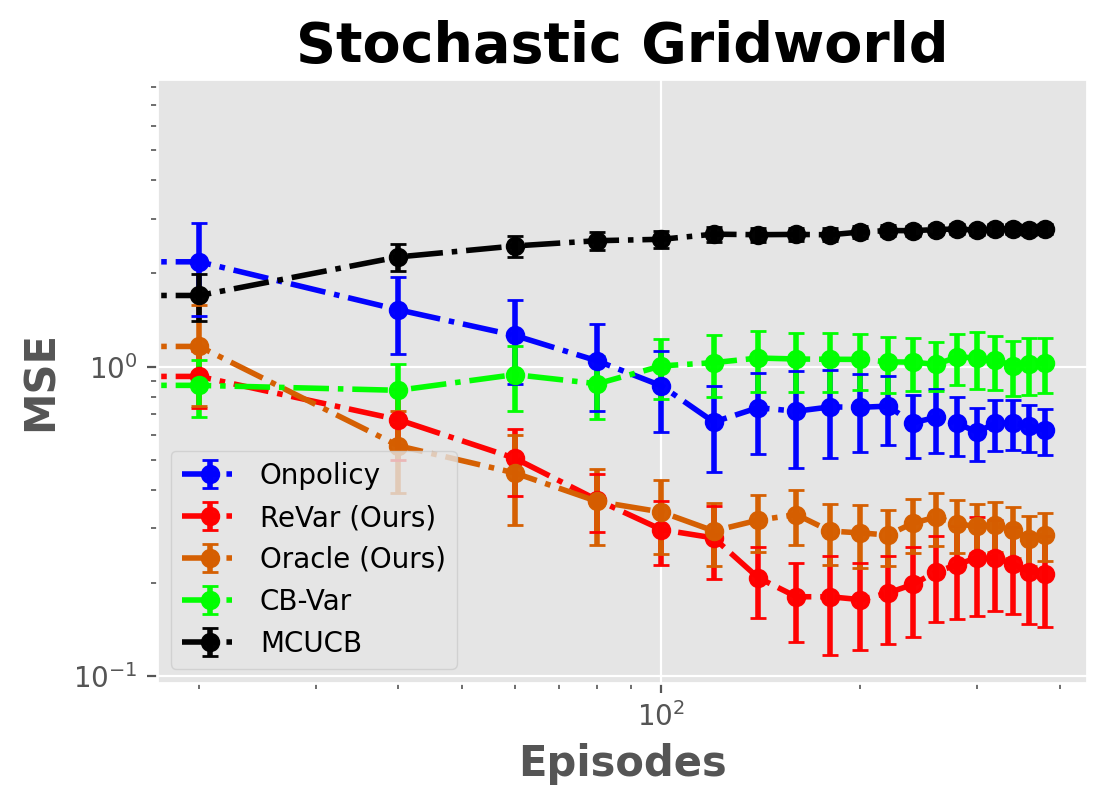

In [ ]:
from numpy.core.fromnumeric import shape
import matplotlib
import matplotlib.pyplot as plt


plt.style.use('ggplot')
plt.figure(dpi=200)

env = Environment()
env.reset()
vi_true = value_iteration()
# v_true = vi_true.run_value_iteration(env.P,env.R_)[0]
v_true = vi_true.run_value_iteration(env.P,env.R_)[0]
print(v_true)


error_onpolicy = (v_pi_onpolicy - v_true)**2
error_ucb_exploration_policy = (v_pi_ucb_exploration_policy - v_true)**2
error_oraclepolicy = (v_pi_oraclepolicy - v_true)**2
error_cbvarpolicy = (v_pi_cbvarpolicy - v_true)**2
error_mcucb_policy = (v_pi_mcucb_policy - v_true)**2

# print(np.shape(error_cbvarpolicy))
# print(error_cbvarpolicy)
# print(env.start_state)

error_onpolicy = error_onpolicy[:,:,env.start_state[0],env.start_state[1]]
error_ucb_exploration_policy = error_ucb_exploration_policy[:,:,env.start_state[0],env.start_state[1]]
error_oraclepolicy = error_oraclepolicy[:,:,env.start_state[0],env.start_state[1]]
error_cbvarpolicy = error_cbvarpolicy[:,:,env.start_state[0],env.start_state[1]]
error_mcucb_policy = error_mcucb_policy[:,:,env.start_state[0],env.start_state[1]]

# error_cbvarpolicy = error_cbvarpolicy[:,:,0,0]


error_onpolicy = np.reshape(error_onpolicy, (env.num_trials, env.episodes))
error_ucb_exploration_policy = np.reshape(error_ucb_exploration_policy, (env.num_trials, env.episodes))
error_oraclepolicy = np.reshape(error_oraclepolicy, (env.num_trials, env.episodes))
error_cbvarpolicy = np.reshape(error_cbvarpolicy, (env.num_trials, env.episodes))
error_mcucb_policy = np.reshape(error_mcucb_policy, (env.num_trials, env.episodes))


scale = np.arange(0, env.episodes, 20)
# print(scale)
# x = np.logspace(1, env.episodes, 20, base = 1.015, endpoint = True)
# scale = [int(i) for i in x]
# print(scale)



k = 0.2
# k = 0.95


# # Plot with error bar
plt.errorbar(scale, [np.average(error_onpolicy, axis=0)[i] for i in scale], [k*np.std(error_onpolicy, axis=0)[i] for i in scale], color = "#0000FF", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 4.0, label='Onpolicy', linestyle = "-.", marker = "o", markersize = 6.0)
plt.errorbar(scale, [np.average(error_ucb_exploration_policy, axis=0)[i] for i in scale], [k*np.std(error_ucb_exploration_policy, axis=0)[i] for i in scale], color = "#FF0000", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 4.0, label='ReVar (Ours)', linestyle = "-.", marker = "o", markersize = 6.0)
plt.errorbar(scale, [np.average(error_oraclepolicy, axis=0)[i] for i in scale], [k*np.std(error_oraclepolicy, axis=0)[i] for i in scale], color = "#D55E00", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 4.0, label='Oracle (Ours)', linestyle = "-.", marker = "o", markersize = 6.0)
plt.errorbar(scale, [np.average(error_cbvarpolicy , axis=0)[i] for i in scale], [k*np.std(error_cbvarpolicy, axis=0)[i] for i in scale], color = "#00FF00", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 4.0, label='CB-Var', linestyle = "-.", marker = "o", markersize = 6.0)
plt.errorbar(scale, [np.average(error_mcucb_policy , axis=0)[i] for i in scale], [k*np.std(error_mcucb_policy, axis=0)[i] for i in scale], color = "#000000", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 4.0, label='MCUCB', linestyle = "-.", marker = "o", markersize = 6.0)


# # Plot without error bar
# plt.plot(scale, [np.average(error_onpolicy, axis=0)[i] for i in scale], color = "#0000FF", linewidth = 2, alpha = 4.0, label='Onpolicy', linestyle = "-", markersize = 6.0)
# plt.plot(scale, [np.average(error_ucb_exploration_policy, axis=0)[i] for i in scale], color = "#FF0000", linewidth = 2, alpha = 4.0, label='Plugin-UCB (Ours)', linestyle = "-", markersize = 6.0)
# plt.plot(scale, [np.average(error_oraclepolicy, axis=0)[i] for i in scale], color = "#D55E00", linewidth = 2, alpha = 4.0, label='Oracle (Ours)', linestyle = "-", markersize = 6.0)
# plt.plot(scale, [np.average(error_cbvarpolicy , axis=0)[i] for i in scale], color = "#00FF00", linewidth = 2, alpha = 4.0, label='CB-Var', linestyle = "-", markersize = 6.0)
plt.yscale('log')
plt.xscale('log')


plt.title('Stochastic Gridworld', size = 20, fontweight='bold')



plt.xlabel("Episodes",fontweight='bold', fontsize = 15)
plt.ylabel("MSE",fontweight='bold', fontsize = 15)



plt.xlabel("Episodes")
plt.ylabel("MSE")

# plt.xlim(1,400)
# plt.ylim(0,1)
plt.legend()

# Load Drive

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Write File

In [ ]:
# import pickle

# f1 = v_pi_onpolicy
# f2 = v_pi_ucb_exploration_policy
# f3 = v_pi_oraclepolicy
# f4 = v_pi_cbvarpolicy
# f5 = v_pi_mcucb_policy



# with open('/content/drive/My Drive/Dataset/ReVar/grid_data2.pickle', 'wb') as handle:
#     pickle.dump([f1, f2, f3, f4, f5], handle, protocol=pickle.HIGHEST_PROTOCOL)


# Read Data

In [38]:
import pickle

with open('/content/drive/My Drive/Dataset/ReVar/grid_data2.pickle', 'rb') as handle:
    b = pickle.load(handle)

v_pi_onpolicy1 = b[0]
v_pi_ucb_exploration_policy1 = b[1]
v_pi_oraclepolicy1 = b[2]
v_pi_cbvarpolicy1 = b[3]
v_pi_mcucb_policy1 = b[4]


# Plot From Read Data

[[-2.74086174 -2.05613591 -1.40309925 -0.84388407]
 [-2.05613591 -1.09170999 -0.10831889  0.36877778]
 [-1.40309925 -0.10831889  1.73755556  3.23333333]
 [-0.84388407  0.36877778  3.23333333 10.        ]]
[1, 1, 1, 2, 3, 4, 6, 9, 12, 16, 23, 31, 43, 59, 80, 110, 151, 206, 282, 385]


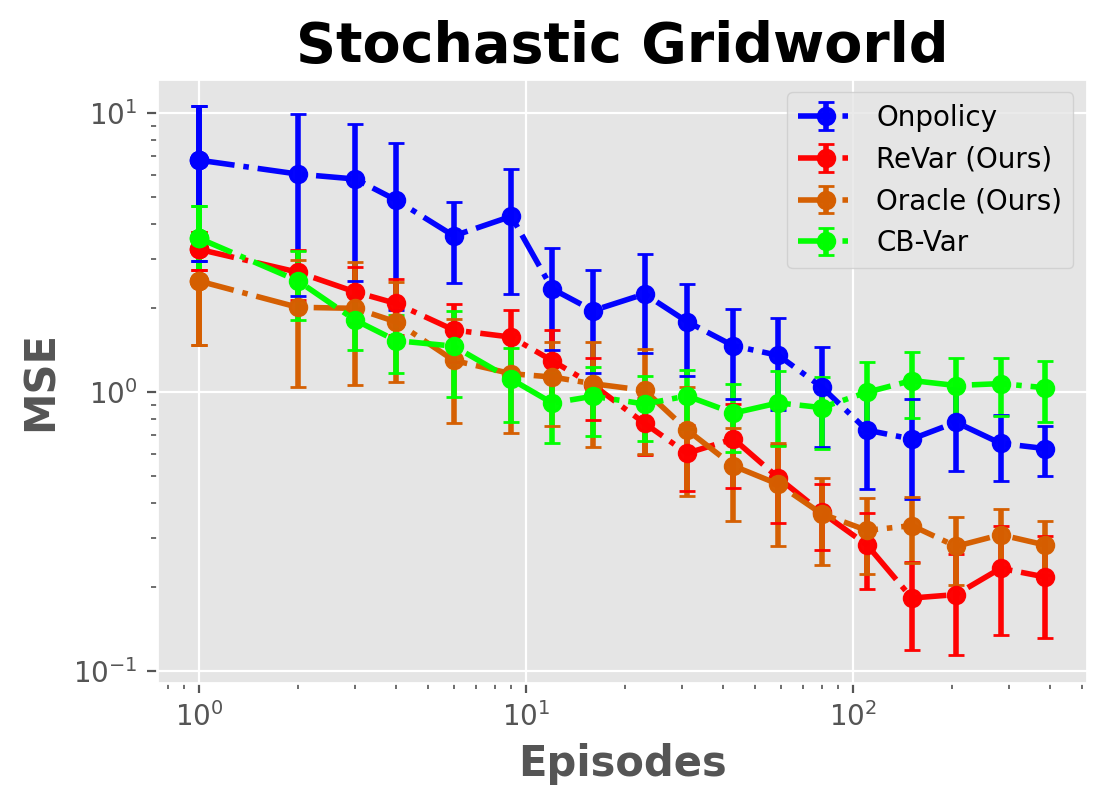

In [45]:
from numpy.core.fromnumeric import shape
import matplotlib
import matplotlib.pyplot as plt


plt.style.use('ggplot')
plt.figure(dpi=200)

env = Environment()
env.reset()
vi_true = value_iteration()
# v_true = vi_true.run_value_iteration(env.P,env.R_)[0]
v_true = vi_true.run_value_iteration(env.P,env.R_)[0]
print(v_true)


error_onpolicy = (v_pi_onpolicy1 - v_true)**2
error_ucb_exploration_policy = (v_pi_ucb_exploration_policy1 - v_true)**2
error_oraclepolicy = (v_pi_oraclepolicy1 - v_true)**2
error_cbvarpolicy = (v_pi_cbvarpolicy1 - v_true)**2
error_mcucb_policy = (v_pi_mcucb_policy1 - v_true)**2

# print(np.shape(error_cbvarpolicy))
# print(error_cbvarpolicy)
# print(env.start_state)

error_onpolicy = error_onpolicy[:,:,env.start_state[0],env.start_state[1]]
error_ucb_exploration_policy = error_ucb_exploration_policy[:,:,env.start_state[0],env.start_state[1]]
error_oraclepolicy = error_oraclepolicy[:,:,env.start_state[0],env.start_state[1]]
error_cbvarpolicy = error_cbvarpolicy[:,:,env.start_state[0],env.start_state[1]]
error_mcucb_policy = error_mcucb_policy[:,:,env.start_state[0],env.start_state[1]]

# error_cbvarpolicy = error_cbvarpolicy[:,:,0,0]


error_onpolicy = np.reshape(error_onpolicy, (env.num_trials, env.episodes))
error_ucb_exploration_policy = np.reshape(error_ucb_exploration_policy, (env.num_trials, env.episodes))
error_oraclepolicy = np.reshape(error_oraclepolicy, (env.num_trials, env.episodes))
error_cbvarpolicy = np.reshape(error_cbvarpolicy, (env.num_trials, env.episodes))
error_mcucb_policy = np.reshape(error_mcucb_policy, (env.num_trials, env.episodes))


# scale = np.arange(0, env.episodes, 10)
# print(scale)
x = np.logspace(1, env.episodes, 20, base = 1.015, endpoint = True)
scale = [int(i) for i in x]
print(scale)



k = 0.25


# # Plot with error bar
plt.errorbar(scale, [np.average(error_onpolicy, axis=0)[i] for i in scale], [k*np.std(error_onpolicy, axis=0)[i] for i in scale], color = "#0000FF", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 4.0, label='Onpolicy', linestyle = "-.", marker = "o", markersize = 6.0)
plt.errorbar(scale, [np.average(error_ucb_exploration_policy, axis=0)[i] for i in scale], [k*np.std(error_ucb_exploration_policy, axis=0)[i] for i in scale], color = "#FF0000", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 4.0, label='ReVar (Ours)', linestyle = "-.", marker = "o", markersize = 6.0)
plt.errorbar(scale, [np.average(error_oraclepolicy, axis=0)[i] for i in scale], [k*np.std(error_oraclepolicy, axis=0)[i] for i in scale], color = "#D55E00", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 4.0, label='Oracle (Ours)', linestyle = "-.", marker = "o", markersize = 6.0)
plt.errorbar(scale, [np.average(error_cbvarpolicy , axis=0)[i] for i in scale], [k*np.std(error_cbvarpolicy, axis=0)[i] for i in scale], color = "#00FF00", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 4.0, label='CB-Var', linestyle = "-.", marker = "o", markersize = 6.0)
# plt.errorbar(scale, [np.average(error_mcucb_policy , axis=0)[i] for i in scale], [k*np.std(error_mcucb_policy, axis=0)[i] for i in scale], color = "#000000", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 4.0, label='MCUCB', linestyle = "-.", marker = "o", markersize = 6.0)


# # Plot without error bar
# plt.plot(scale, [np.average(error_onpolicy, axis=0)[i] for i in scale], color = "#0000FF", linewidth = 2, alpha = 4.0, label='Onpolicy', linestyle = "-", markersize = 6.0)
# plt.plot(scale, [np.average(error_ucb_exploration_policy, axis=0)[i] for i in scale], color = "#FF0000", linewidth = 2, alpha = 4.0, label='Plugin-UCB (Ours)', linestyle = "-", markersize = 6.0)
# plt.plot(scale, [np.average(error_oraclepolicy, axis=0)[i] for i in scale], color = "#D55E00", linewidth = 2, alpha = 4.0, label='Oracle (Ours)', linestyle = "-", markersize = 6.0)
# plt.plot(scale, [np.average(error_cbvarpolicy , axis=0)[i] for i in scale], color = "#00FF00", linewidth = 2, alpha = 4.0, label='CB-Var', linestyle = "-", markersize = 6.0)
plt.yscale('log')
plt.xscale('log')


plt.title('Stochastic Gridworld', size = 20, fontweight='bold')



plt.xlabel("Episodes",fontweight='bold', fontsize = 15)
plt.ylabel("MSE",fontweight='bold', fontsize = 15)



plt.xlabel("Episodes")
plt.ylabel("MSE")

# plt.xlim(1,125)
# plt.ylim(0,1)
plt.legend()